## Summary of this notebook

In the [last notebook](./3_data_processing.ipynb), we finished preparing our data.  In this notebook, we do some basic exploratory data analysis and then create linear regression models to predict house sale prices.

NOTE: All of our EDA is performed after *only importing the main part of our training data*.  We already reserved a separate chunk of about 300 observations in the [reserved data set](../datasets/train_processed_reserved.csv) so that we can validate our models; we will bring this data in only once we have fit our models / hyperparameters.  The `test_processed.csv` file will only be used for the purposes of the Kaggle competition associated with this project - we can't use it to validate our models since it lacks any `SalePrice` data.

## Package imports

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

import itertools

## Import training data (but not reserved training data)

In [2]:
#Data import
df = pd.read_csv('../datasets/train_processed.csv')
len(df)

1734

## Aside: Categorical Variable Encoding

Several categorical variables in this data set may convey information but may add too many parameters to our model (and lead to overfitting) if one-hot encoded.  Later, we will use LASSO regularized regression to drop those dummy variables produced by one-hot encoding that are not sufficiently explanatory of home sale prices.  However, we may also want to try a more direct approach to reduce the number of parameters in our model.

Instead of one-hot encoding all of these categorical variables, we can also encode them in a simpler form.  The function below carries out one possible such encoding; it turns a categorical variable into a numeric variable that only takes on the values 1, 0 and -1 based on whether they're associated with higher or lower values of our target variable `SalePrice`.  1 corresponds to "above average", 0 to "about average", and -1 to "below average."  See the example below, after the function's code.

In [3]:
def above_below_mid(df, col, target):
    '''
    Inputs:
    -A Pandas dataframe df
    -The name of a (categorical) column in df
    -The name of the target (numeric) column to be predicted by modeling
    
    Output:
    Returns a dicticonary that sorts each value appearing in that column
    to 1 if it's associated with above-median target value, -1 if it's
    associated with a below-median target value, and 0 if it's associated
    with an approximately-median target value.
    
    Specifically, this function does:
    1. For each value 's' that is taken on in that column,
     find the conditional median of the target value given that
     df[col]=='s';
    2. Find the range of these conditional medians, i.e.
     [LOWEST CND MEDIAN, HIGHEST CND MEDIAN];
    3. For each value 's' that is taken on in that column,
      -Appends {'s':1} to the output dict if the conditional median
      for 's' was in the top third of this range;
      -Appends {'s':0} if it was in the middle thrid;
      -Appends {'s':-1} if it was in the bottom third.
    '''
    
    output={}
    meds={}
    pop_med = df[target].median()
    
    #Make a dictionary of conditional medians for each value in the column
    for name in df[col].unique():
        
        #Find conditional median of target for that value
        cnd_med = df[ df[col]==name ][target].median()
        meds[name] = cnd_med
            
    #Find the most extreme conditional medians
    highest_med = max(meds.values())
    lowest_med = min(meds.values())
    diff = highest_med - lowest_med

    #Group the column's values based on whether their conditional target mean
    #is in the lower thrid (-1), upper third (1), or middle third (0)
    
    for name in meds.keys():
        if meds[name] < lowest_med + diff/3:
            output[name] = -1
        elif meds[name] > highest_med - diff/3:
            output[name] = 1
        else:
            output[name] = 0
    
    return output
    

In [4]:
#An example
above_below_mid(df, col='Condition 1', target='SalePrice')

{'Norm': 0,
 'RRAn': 0,
 'PosA': 1,
 'Artery': -1,
 'Feedr': -1,
 'RRAe': -1,
 'PosN': 1,
 'RRNe': -1,
 'RRNn': 0}

Those strings that are assigned -1 can be thought of as associated with below-average home prices; those assigned +1 are associated with above-average home prices; and those assigned 0 are associated with approximately average prices.

Looking at the [data description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) for the feature `Condition 1`, we can see that these assignments make a good deal of sense.  The value 'RRAe' is mapped to -1, which fits with the idea that being *adjacent to a railrod* probably leads to lower home prices.  The value 'Norm' is mapped to 0, which means that "Normal" (according to the data description) houses have approximately average prices.  'PosA' is described as "Adjacent to postive off-site feature," and we see that it's mapped to 1, corresponding to higher-than-average home prices.

We will return to encoding the categorical variables later.  For now, we'll deal with the data types.

# Exploratory Data Analysis

Before we do any modeling, we'll want to look at the distribution of our target variable `SalePrice`.  Let's start with some summary statistics:

In [5]:
df['SalePrice'].describe()

count      1734.000000
mean     181433.705882
std       79094.317113
min       12789.000000
25%      129575.000000
50%      163000.000000
75%      213812.500000
max      611657.000000
Name: SalePrice, dtype: float64

Since the mean is larger than the median, we can see that the distribution of homes' prices is skewed right.  It's also worth noting that homes' prices go as low as about 13,000 dollars and as high as about 612,000 dollars.  Let's examine the histogram:

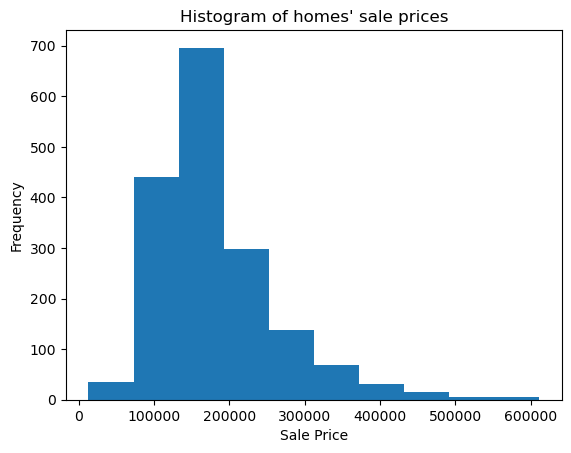

In [6]:
plt.hist(df['SalePrice']);
plt.xlabel('Sale Price');
plt.ylabel('Frequency');
plt.title("Histogram of homes' sale prices");

This looks like a logarithmic transform may make the distribution of our target variable closer to Normal.  Let's try it:

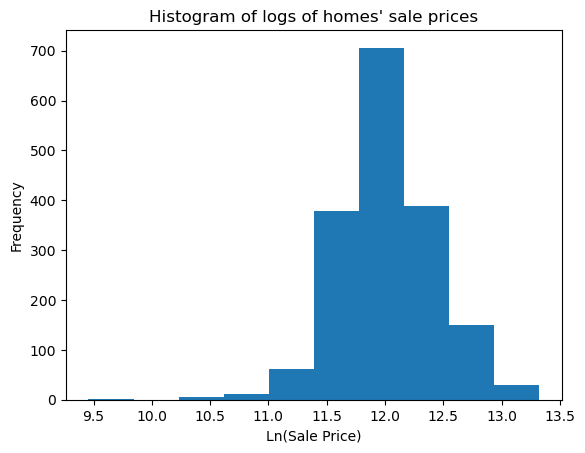

In [7]:
plt.hist(np.log(df['SalePrice']))
plt.xlabel('Ln(Sale Price)');
plt.ylabel('Frequency');
plt.title("Histogram of logs of homes' sale prices");

This does indeed look closer to Normal.  Let's check out its summary statistics:

In [8]:
df['SalePrice'].map(lambda x : np.log(x)).describe()

count    1734.000000
mean       12.025033
std         0.408120
min         9.456341
25%        11.772015
50%        12.001505
75%        12.272854
max        13.323927
Name: SalePrice, dtype: float64

This time, the mean is pretty close to the median - the distribution is only *slightly* skewed right.

## Numeric variables' correlations with `SalePrice`

Now that we've seen the distribution of our target variable `SalePrice`, let's examine the relationships between the various other features and `SalePrice`.  We'll start with the numeric features, as we can easily examine their correlations with sale price.

In [9]:
#Extract the numeric and categorical features
numerics = []
categoricals = []

for feature in df.dtypes.index:
    if (df.dtypes[feature] == 'int64') or (df.dtypes[feature] == 'float64'):
        numerics.append(feature)
    else:
        categoricals.append(feature)
        
print(f"Numeric variables include {numerics[:5]}")
print(f"Categorical variables incl {categoricals[:5]}")

Numeric variables include ['Id', 'Lot Frontage', 'Lot Area', 'Lot Shape', 'Utilities']
Categorical variables incl ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour']


In [10]:
#Remove the ID number since it's not predictive
numerics.remove('Id')

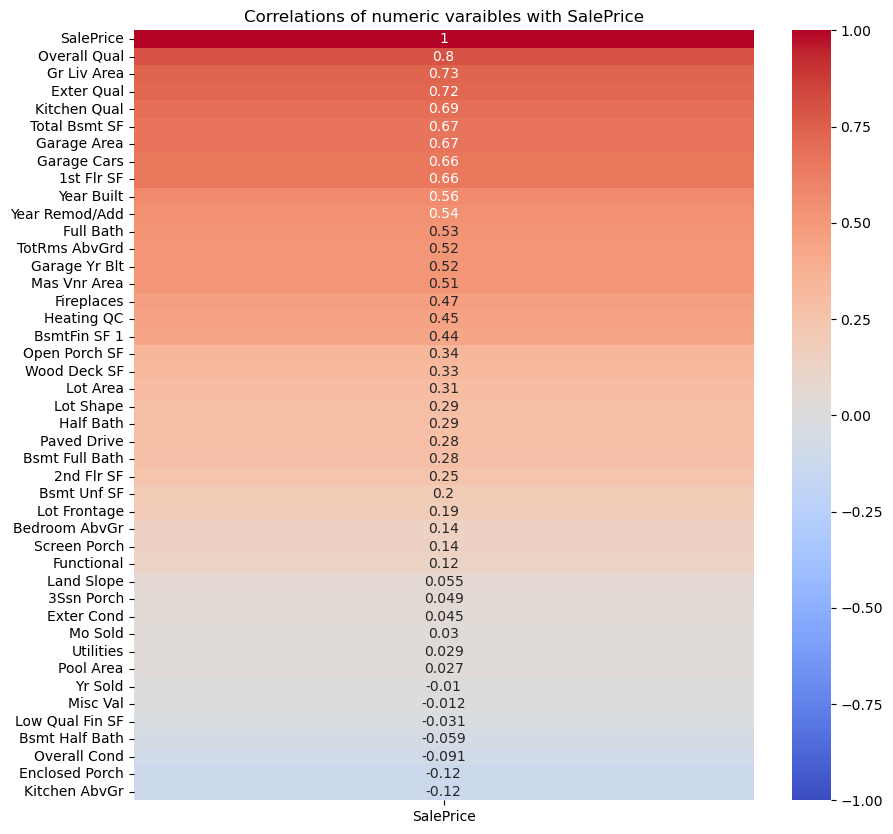

In [11]:
#Get a heatmap of correlations of numeric features with SalePrice
plt.figure(figsize=(10,10))
sns.heatmap(df[numerics].corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False),
           cmap = 'coolwarm',
           vmax = 1,
           vmin = -1,
           annot = True);
plt.title('Correlations of numeric varaibles with SalePrice');

Those features at the top of this list seem like great candidates to include in a basic regression trying to predict `SalePrice`.  Those at the bottom are much less likely to be useful.

For now, let's make a list of those numeric variablenames that are most correlated with `SalePrice` (say, correlation greater than .3):

In [12]:
nums_strong = [x for x in df[numerics].columns if df[x].corr(df['SalePrice'])>.3]
nums_strong

['Lot Area',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'Exter Qual',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 'Heating QC',
 '1st Flr SF',
 'Gr Liv Area',
 'Full Bath',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'SalePrice']

### Numeric features' relationships with each other

Now let's make sure none of these features are too strongly correlated with each other:

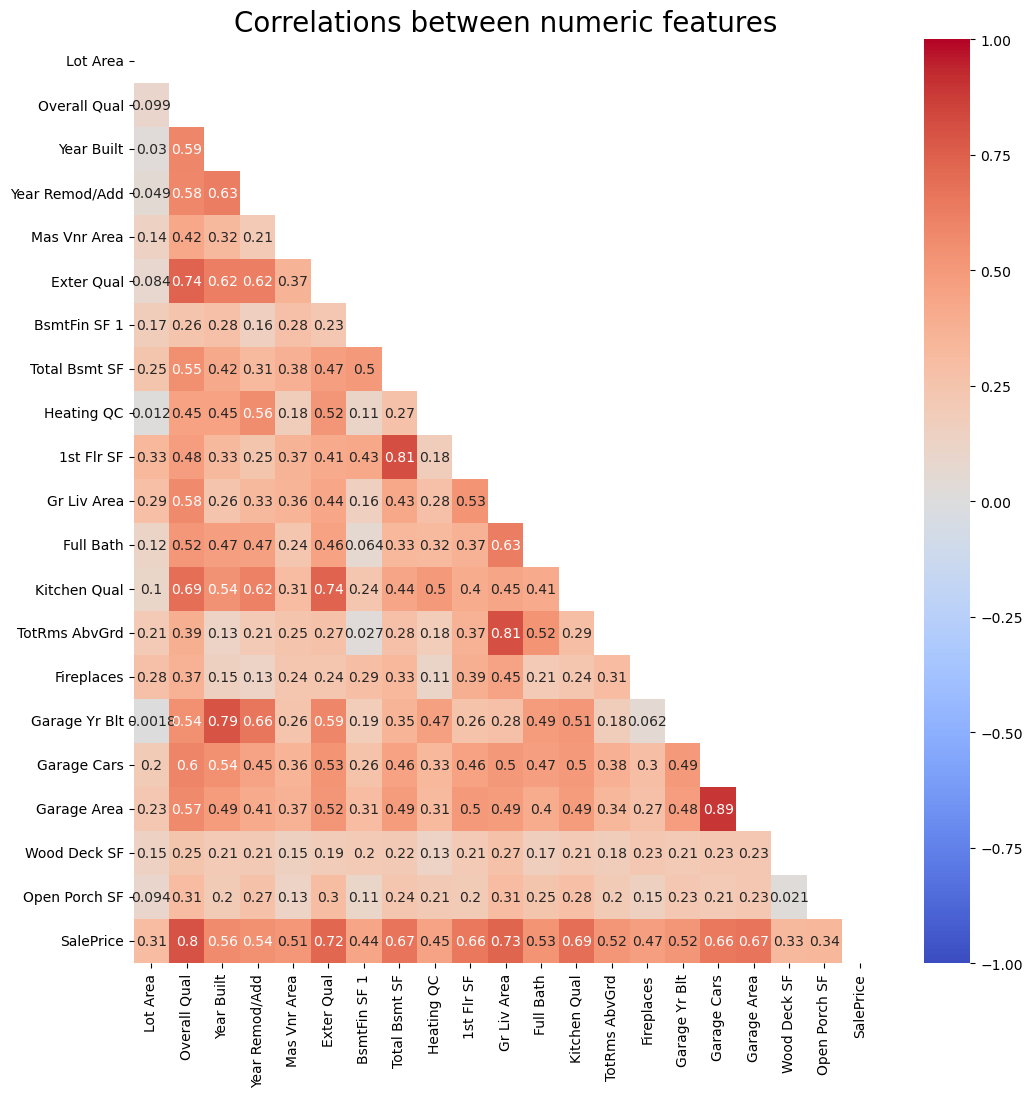

In [13]:
corr = df[nums_strong].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(12,12));
sns.heatmap(corr,
            cmap = 'coolwarm',
            vmin=-1,
            vmax=1,
            annot=True,
            mask=mask);
plt.title('Correlations between numeric features', size=20);

We see that `Garage Area` and `Garage Cars` are highly correlated - which makes sense, since the latter measures how may cars fit in the garage!  This seems like a good reason to drop this feature from our list, as it's likely measuring almost the same thing as `Garage Area` (and `Garage Area` was slightly *more* correlated with `SalePrice`).

Some other variables have correlations as high as .81, but there's no obvious reason that they should be multicollinear.  So we'll leave them in our list for now.

In [14]:
#Remove the multicollinear and target variables from our list of strong numeric vars
nums_strong.remove('Garage Cars')
nums_strong.remove('SalePrice')
len(nums_strong)

19

Finally, let's make pair plots to examine the relationships between those features that have a correlation with `SalePrice` of at least .6:

In [15]:
nums_vstrong = [x for x in df[numerics].columns if df[x].corr(df['SalePrice'])>.6]
nums_vstrong.remove('Garage Cars')

<Figure size 1400x1400 with 0 Axes>

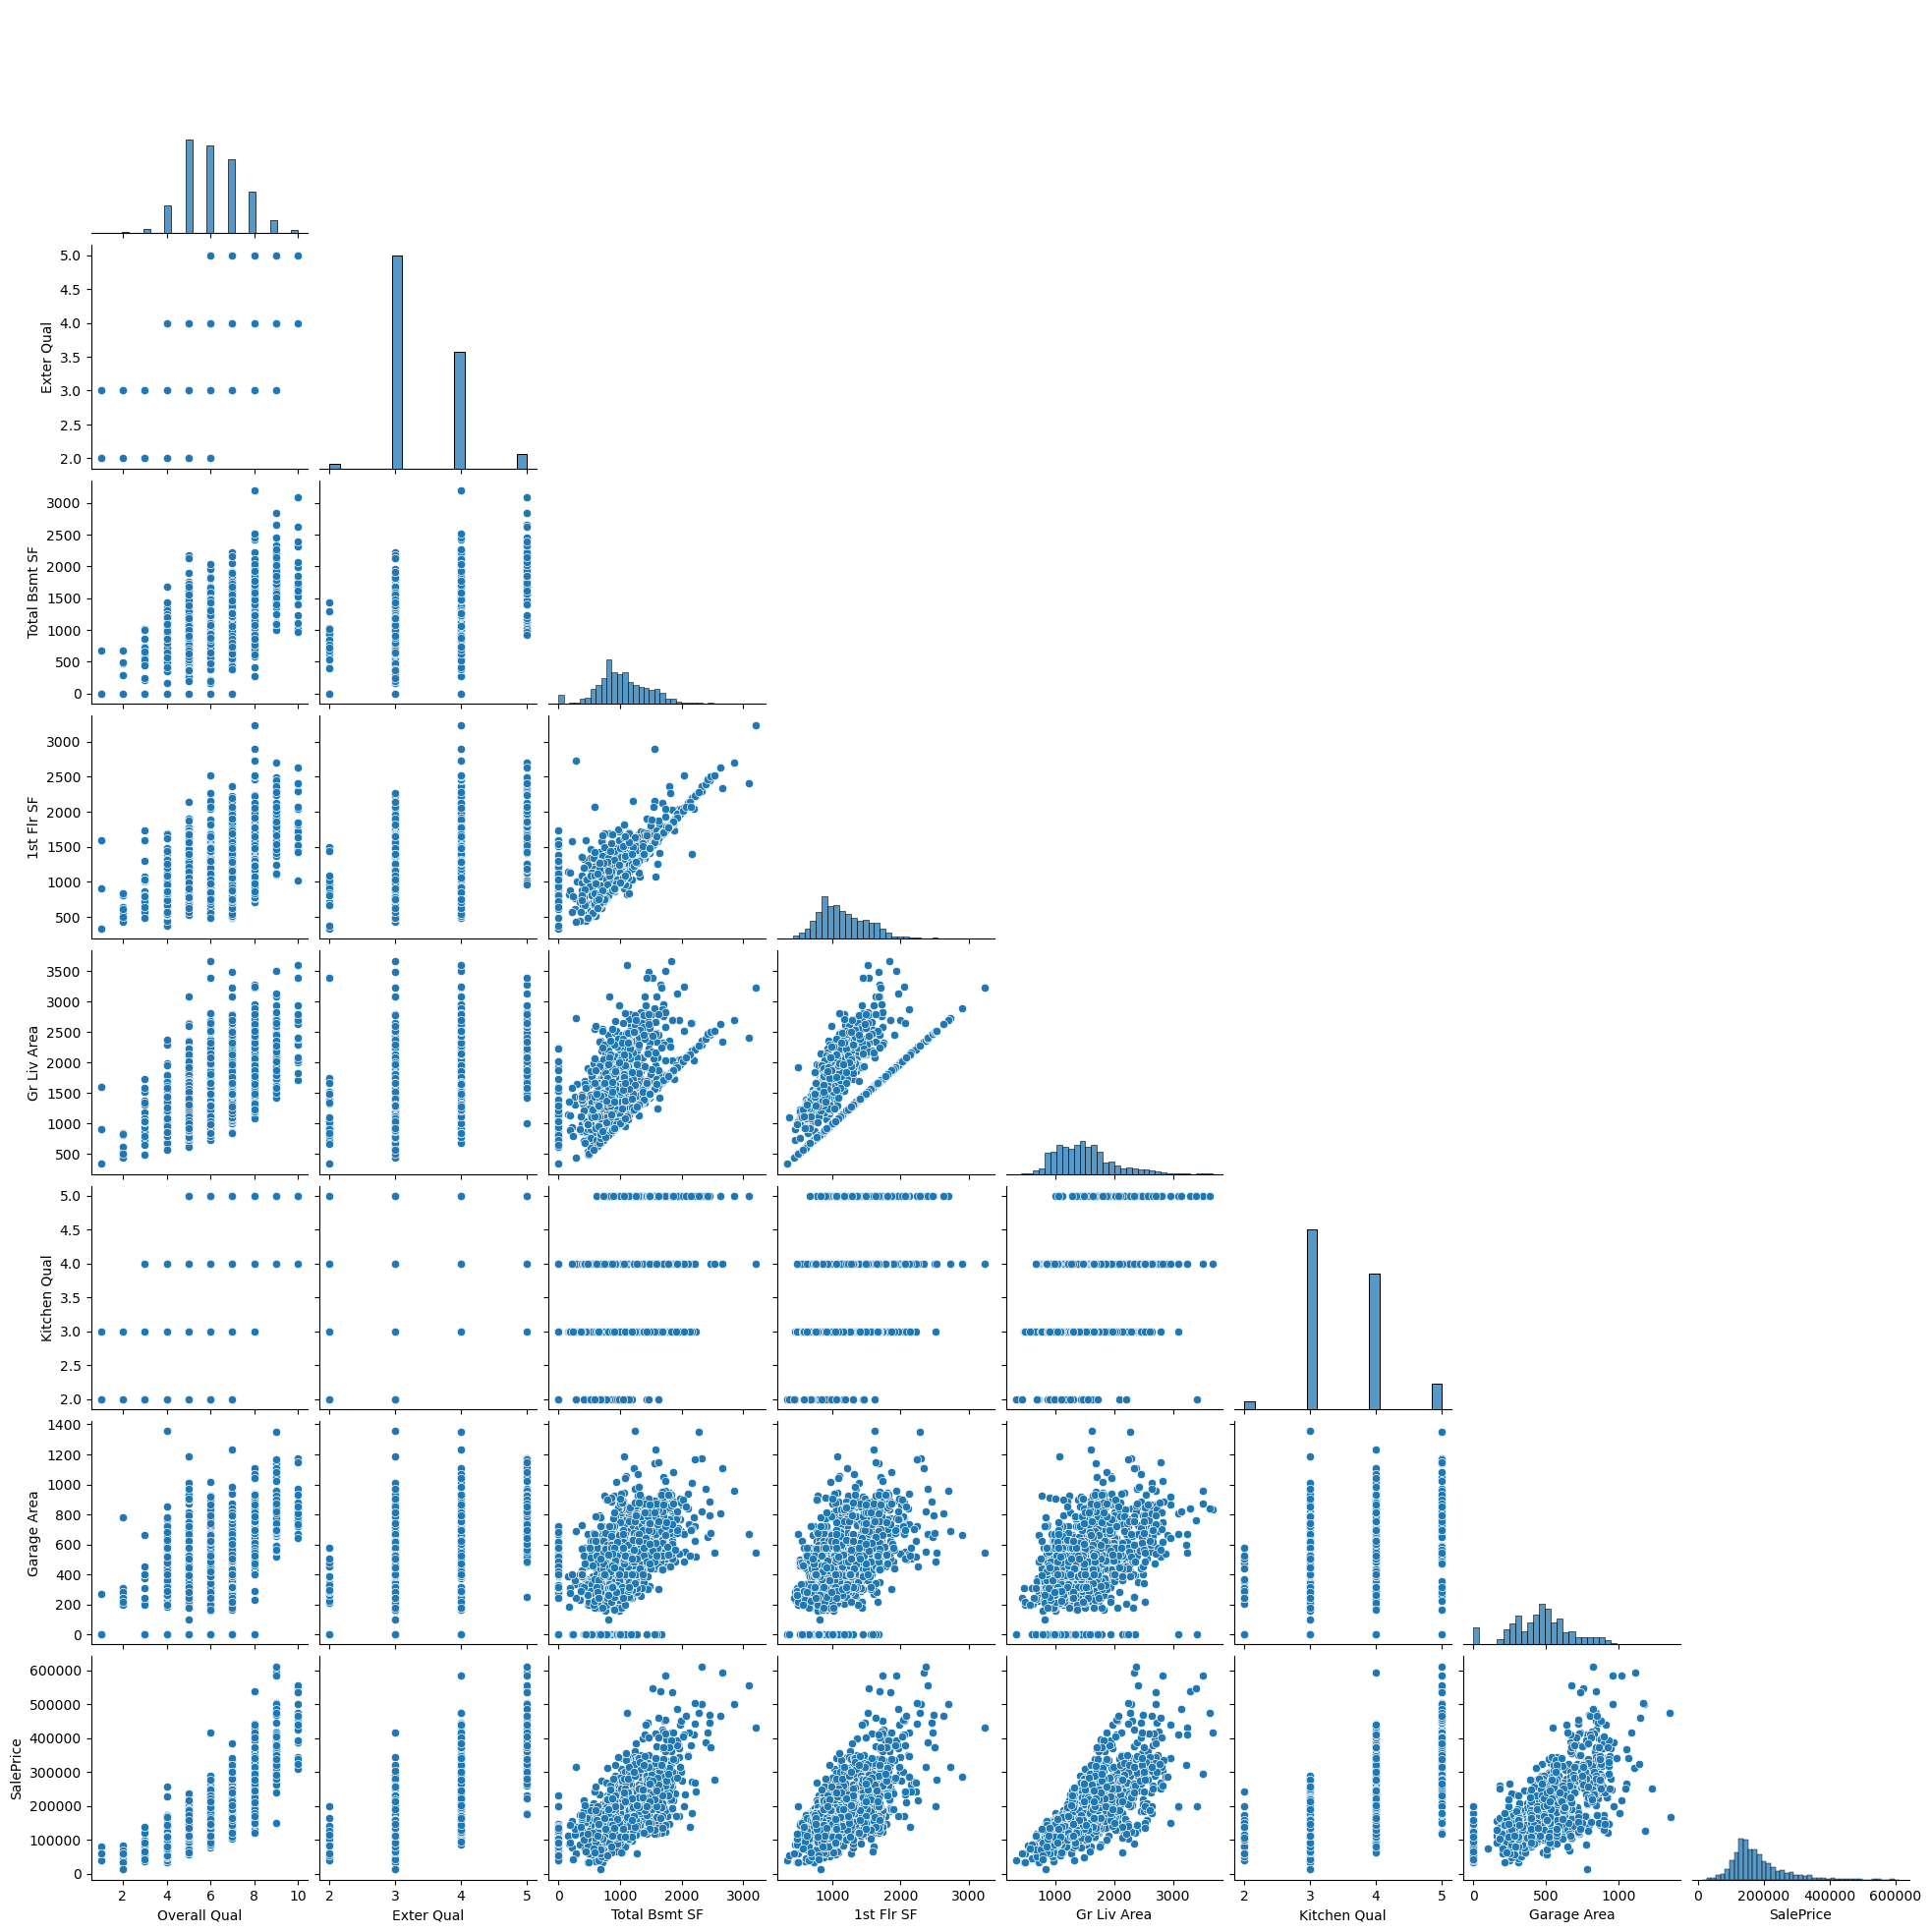

In [16]:
plt.figure(figsize=(14,14));

sns.pairplot(df[nums_vstrong], corner=True);

As we can see from the bottom row, most of these features do seem to have an approximately linear relationship with `SalePrice`.  There is a little bit of "fanning out" (heteroskedasticity) of the sale prices as the features get larger, which again suggests that a logarithmic transformation of `SalePrice` may improve our linear model's predictive power.

We also see that some of these otherwise-regular-looking plots contain vertical or horizontal lines at 0.  These simply account for the mass homes with e.g. zero basement square footage or garage square footage (because they don't have a basement / don't have a garage).

Finally, there are some diagonal lines that appear in some of the scatterplots of the square footage variables against each other.  These likely indicate cases where the person who assessed the home's square footage just split up the total square footage roughly evenly between its various floors/regions (perhaps because the house is very regularly shaped).

In [17]:
#Record for later those numeric features most strongly correlated with SalePrice
nums_vstrong.remove('SalePrice')
len(nums_vstrong)

7

## Categorical variables' correlations with `SalePrice`

In order to be able to examine correlations of categorical variables with `SalePrice`, we'll first have to find a way to encode those variables as numbers.  Rather than make dummies of everything (and get a truly enormous heatmap), we'll start by just applying the `above_below_mid` transformation function from the "Aside: Encoding Categorical Variables" section above.  This function encodes those categories that are associated with "above average" `SalePrice` as 1, those associated with below average `SalePrice` as -1, and those associated with approximately average `SalePrice` as 0.

In [18]:
cat_df = df[categoricals + ['SalePrice']]

#Encode all the non-SalePrice values with above_below_mid
for col in cat_df.columns:
    if col != 'SalePrice':
        map_dict = above_below_mid(cat_df, col, 'SalePrice')
        cat_df[col] = cat_df.loc[:,col].map(map_dict)
        
cat_df.head()

,MS SubClass,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,...,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Pool QC,Fence,Misc Feature,Sale Type,SalePrice
0,1,1,1,1,-1,-1,0,0,-1,1,...,0,1,1,0,1,-1,1,-1,-1,257000
1,0,0,1,1,-1,-1,-1,0,-1,-1,...,-1,-1,-1,0,1,-1,1,-1,-1,113500
2,1,1,1,1,1,0,1,0,-1,1,...,0,1,1,0,1,-1,1,-1,-1,538000
3,1,1,1,1,1,0,1,0,-1,1,...,-1,1,1,0,1,-1,1,-1,-1,275000
4,0,1,1,1,-1,-1,0,0,-1,1,...,-1,1,1,0,1,-1,1,-1,-1,143450


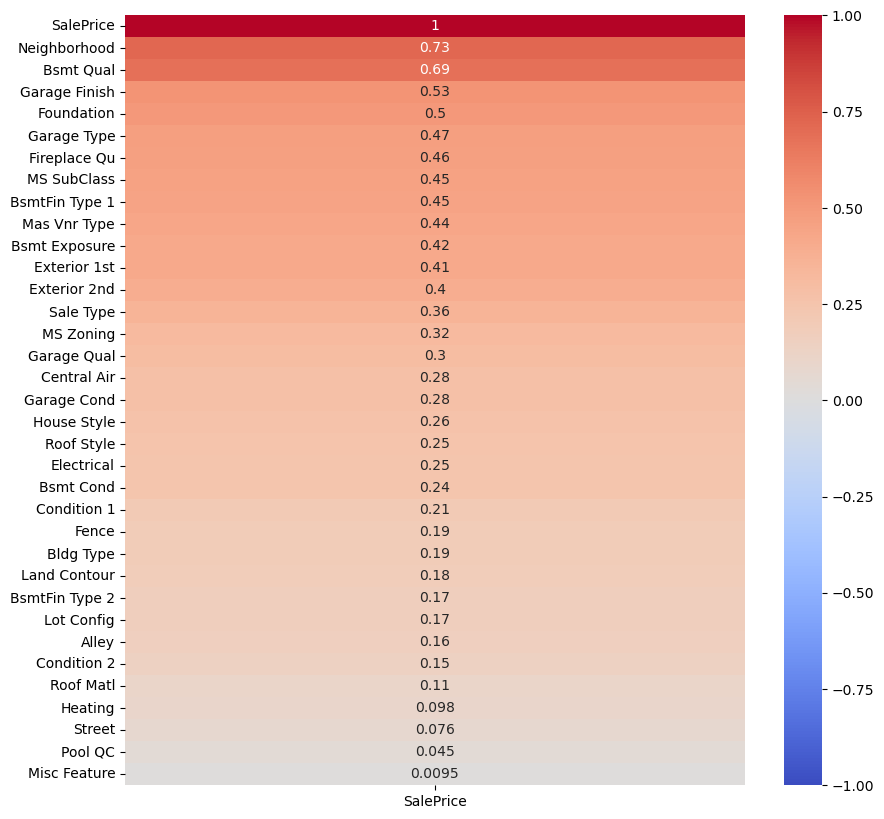

In [19]:
#Get a heatmap of correlations of categorical features with SalePrice
plt.figure(figsize=(10,10))
sns.heatmap(cat_df.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False),
           cmap = 'coolwarm',
           vmax = 1,
           vmin = -1,
           annot = True);

Those features at the top of this list are likely to be somewhat informative when included in a regression.  Those at the bottom are less likely to be informative.  Let's get a list  of those variables that (after the encoding above) have a correlation with `SalePrice` of magnitude at least .3:

In [20]:
cats_strong = [x for x in cat_df.columns if cat_df[x].corr(df['SalePrice'])>.3]
cats_strong

['MS SubClass',
 'MS Zoning',
 'Neighborhood',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Sale Type',
 'SalePrice']

### (Transformed) Categorical Variables' relationships with each other

Now let's make sure none of these categorical features are too strongly correlated with each other:

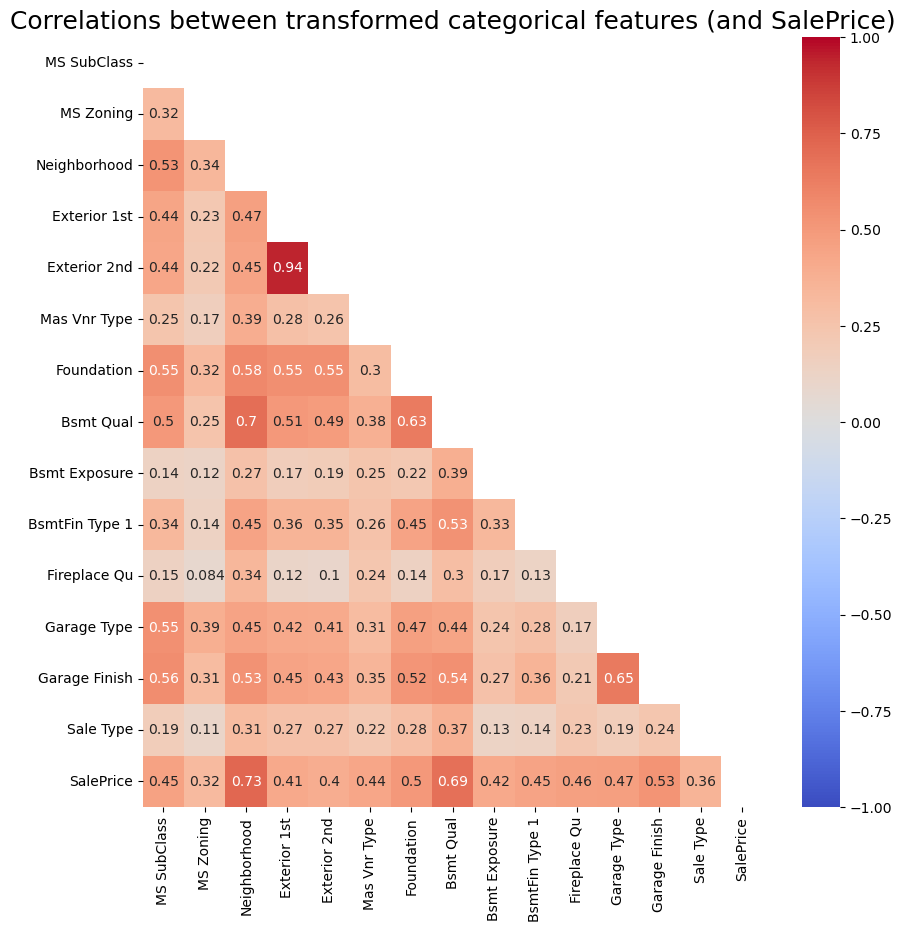

In [21]:
corr = cat_df[cats_strong].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(10,10));
sns.heatmap(corr,
            cmap = 'coolwarm',
            vmin=-1,
            vmax=1,
            annot=True,
            mask=mask);
plt.title('Correlations between transformed categorical features (and SalePrice)', size=18);

We see that `Exterior 1st` and `Exterior 2nd` are highly correlated.  Looking at the [data description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), we see that `Exterior 1st` represents the type of material covering the house, while `Exterior 2nd` represents the *second type of material covering the house, if there is any different from the primary one*.  It seems that the vast majority of homes only have one type of material covering them, leading `Exterior 1st` and `Exterior 2nd` to be nearly identical variables.

To avoid (near) multicollinearity, we'll drop `Exterior 2nd` (the one less correlated with `SalePrice`) from our list of categorical variables to consider in our initial model.

Some other variables have correlations as high as .73, but there's no obvious reason that they should be multicollinear.  So we'll leave them in our list for now.

In [22]:
#Remove the multicollinear and target variables from our list of strong numeric vars
cats_strong.remove('Exterior 2nd')
cats_strong.remove('SalePrice')
len(cats_strong)

13

Finally, let's make a list of those categorical variables that are *extremely strongly* correlated with `SalePrice`.

In [23]:
cats_vstrong = [x for x in cat_df.columns if cat_df[x].corr(df['SalePrice'])>.6]
cats_vstrong.remove('SalePrice')
cats_vstrong

['Neighborhood', 'Bsmt Qual']

# Regression Modeling

We now have a list `cats_strong` of the 13 categorical variables that are (after transformation) that have a correlation with `SalePrice` of more than .3.  Combining these with our similar list `nums_strong` of 19 numeric variables, we have a good starting point of which varaibles to include in a linear regression to predict `SalePrice`.

In case this is too many varaibles, we also have the lists `nums_vstrong` (7 varaibles) and `cats_vstrong` (2 varaibles), which include only those variables whose correlation with `SalePrice` is at more than .6.

When we include categorical varaibles in a regression, we need to encode them as numeric variables in some way.  We will try two methods:
1. One-hot encoding;
2. `above_below_mid` encoding as above.

We will use a LASSO regularized regression to then drop insignificant features from our regression.  I suspect that the net result after applying LASSO will be better (in terms of cross-val and testing $R^2$) when using approach \#1 above, as LASSO eliminates the non-useful dummies.  But we shall see!

Before the validation phase of the modeling process, we'll evaluate these models using their cross-val scores on our loaded dataset `df`.  Recall that this data set was made from 85% of our originally available training data; we won't use our reserved test data (the 15% chunk we took off of the training data set) until we want to validate our models.  But for now, we need to read in this reserved data (into a dataframe we'll call `tests`), and then make a second transformed dataframe `cat_tests` that has applied the `above_below_mid` encoding to the categorical variables as we did to our training data set.

## Read in the reserved data set

In [122]:
tests = pd.read_csv('../datasets/train_processed_reserved.csv')

In [123]:
cat_tests = tests[categoricals + ['SalePrice']]

#Encode all the non-SalePrice values with above_below_mid
for col in cat_tests.columns:
    if col != 'SalePrice':
        map_dict = above_below_mid(cat_tests, col, 'SalePrice')
        cat_tests[col] = cat_tests.loc[:,col].map(map_dict)

In [124]:
#Make a transformed test data df
abm_tests = tests
for col in categoricals:
    #Get the transformed values from the cat_tests we already made
    abm_tests[col] = cat_tests[col]
abm_tests.head()

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,2461,0,1,72.0,8640,0,0,0,-1,4,...,0,0,-1,1,1,0,10,2006,1,198600
1,2814,1,0,68.0,8846,0,0,0,-1,4,...,0,0,-1,1,1,0,8,2006,1,173900
2,2267,1,0,0.0,9303,0,0,1,-1,4,...,0,0,-1,1,1,0,7,2007,0,204000
3,2644,-1,0,70.0,5684,0,0,0,-1,4,...,0,0,-1,1,1,0,6,2006,0,110000
4,649,0,0,60.0,7626,0,0,0,-1,4,...,0,0,-1,-1,1,0,3,2009,0,145500


## Baseline Models

In this section, we'll create some basic linear regression models for `SalePrice` using some numeric features and/or some `above_below_mid` encoded categorical features.

In [125]:
y = df['SalePrice']

First, let's only include those features in `nums_vstrong` in a simple linear regression:

In [126]:
#How well does this simple model do?
cross_val_score(LinearRegression(), df[nums_vstrong], y).mean()

0.8418591602995882

This is a pretty good cross-val $R^2$ score for a first try!  It says that on average across 5 random splits of our data into training and test sets, our model can explain about 84% of the variability in `SalePrice` using just its linear relationship with the 7 numerical features in `nums_vstrong`.  But does this model perform well on our reserved data?

In [128]:
lr = LinearRegression()
lr.fit(df[nums_vstrong], y)
lr.score(tests[nums_vstrong], tests['SalePrice'])

0.824708341625942

So this model does almost as well on the reserved data set as it does on the training data set.  Let's also find its mean absolute error (MAE):

In [129]:
metrics.mean_absolute_error(y, lr.predict(df[nums_vstrong]))

22584.309075321933

This means that on average, this basic model's `SalePrice` predictions are off by about $22,600.  Not too bad, but it could be better!

Now let's add the two categorical variables from `cats_vstrong`.  Let's apply our `above_below_mid` (abm) transformation to these categorical variables, just to keep things to a simple 9-coefficient model (rather than making lots of dummy variables that need their own coefficients).  First, we'll have to make a dataframe containing all of our abm-transformed categorical variables plus our original numeric variables:

In [130]:
abm_df = df
for col in categoricals:
    #Get the transformed values from the cat_df we already made
    abm_df[col] = cat_df[col]
abm_df.head()

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,1118,1,1,73.0,9801,1,1,0,-1,4,...,0,0,-1,1,-1,0,7,2008,-1,257000
1,1676,0,0,21.0,2205,1,1,0,-1,4,...,0,0,-1,1,-1,0,2,2007,-1,113500
2,16,1,1,47.0,53504,1,1,2,1,4,...,210,0,-1,1,-1,0,6,2010,-1,538000
3,2329,1,1,0.0,6563,1,1,1,1,4,...,0,0,-1,1,-1,0,12,2006,-1,275000
4,1864,0,1,78.0,11700,1,1,0,-1,4,...,0,0,-1,1,-1,0,9,2007,-1,143450


In [131]:
#Linear regression with strongest numeric and categorical variables only
cross_val_score(LinearRegression(), abm_df[nums_vstrong + cats_vstrong], y).mean()

0.8533086190731737

As we can see, our cross-val $R^2$ score improved by a little bit.  How about the score on the reserved data?

In [132]:
lr = LinearRegression()
lr.fit(df[nums_vstrong + cats_vstrong], y)
lr.score(tests[nums_vstrong + cats_vstrong], tests['SalePrice'])

0.8458689793096263

## Making a dataframe of results from various models

Before adding more variables, let's automate the process a bit so that our results will be more organized and easier to understand.  Below, we try every combination of (strongest only, strong only, all, none) numeric variables with (strongest only, strong only, all, none) categorical variables, each time using `above_below_mid` to encode the categorical variables.  In each case, we try tranforming the target variable `SalePrice` with a logarithmic transformation, or not doing so.  We record the results of all of these models in a dictionary called `results`, then we display them in a dataframe below.

In [148]:
names_dict = { 'strongest categoricals' : cats_vstrong,
               'strongest numerics' : nums_vstrong,
               'strong categoricals' : cats_strong,
               'strong numerics' : nums_strong,
               'all numerics' : numerics,
               'all categoricals' : categoricals,
               'none' : []
}

cat_types = [ 'none', 'strongest categoricals', 'strong categoricals', 'all categoricals' ]
num_types = [ 'none', 'strongest numerics', 'strong numerics', 'all numerics' ]
y_transforms = ['log', 'no transform']

results = {}

for (num_name, cat_name, transform) in itertools.product(num_types , cat_types, y_transforms):
    nums = names_dict[num_name]
    cats = names_dict[cat_name]
    
    #Don't try to regress on an empty set of features
    if nums==[] and cats==[]:
        continue
        
    X_train = abm_df[nums + cats]
    X_test = abm_tests[nums + cats]
        
    if transform == 'no transform':
        y_train = abm_df['SalePrice']
        y_test = abm_tests['SalePrice']
        
    if transform == 'log':
        y_train = np.log(abm_df['SalePrice'])
        y_test = np.log(abm_tests['SalePrice'])
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    reg_name = f"{num_name}, {cat_name}, {transform} on y"
    
    if transform == 'no transform':
        mae_train = metrics.mean_absolute_error(y_train, lr.predict(X_train))
        mae_test = metrics.mean_absolute_error(y_test, lr.predict(X_test))
        rmse_train = metrics.mean_squared_error(y_train, lr.predict(X_train) , squared=False)
        rmse_test = metrics.mean_squared_error(y_test, lr.predict(X_test) , squared=False)
        r2_train = metrics.r2_score(y_train, lr.predict(X_train))
        r2_test = metrics.r2_score(y_test, lr.predict(X_test))
        
    if transform == 'log':
        mae_train = metrics.mean_absolute_error(np.exp(y_train), np.exp(lr.predict(X_train)))
        mae_test = metrics.mean_absolute_error(np.exp(y_test), np.exp(lr.predict(X_test)))
        rmse_train = metrics.mean_squared_error(np.exp(y_train), np.exp(lr.predict(X_train)) , squared=False)
        rmse_test = metrics.mean_squared_error(np.exp(y_test), np.exp(lr.predict(X_test)) , squared=False)
        r2_train = metrics.r2_score(np.exp(y_train), np.exp(lr.predict(X_train)))
        r2_test = metrics.r2_score(np.exp(y_test), np.exp(lr.predict(X_test)))
    
    results[reg_name] = {
        'crossval' : cross_val_score(lr,X_train,y_train).mean(),
        'r2_train' : r2_train,
        'r2_test' : r2_test,
        'mae_train' : mae_train,
        'mae_test' : mae_test,
        'rmse_train' : rmse_train,
        'rmse_test' : rmse_test
    }


In [150]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.sort_values('crossval', ascending=False).head(10)

,crossval,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
"all numerics, strong categoricals, log on y",0.906743,0.939499,0.902690,13748.916205,16559.201198,19449.203164,25210.103051
"all numerics, all categoricals, log on y",0.906007,0.942315,0.290448,13356.512925,58039.511602,18991.228546,68075.126042
"all numerics, strongest categoricals, log on y",0.901783,0.933110,0.907981,14175.031025,15815.521996,20450.285371,24515.174408
"all numerics, none, log on y",0.900628,0.931245,0.906045,14320.181431,15878.087185,20733.445308,24771.699374
"all numerics, all categoricals, no transform on y",0.899538,0.913907,0.403606,16577.585507,56038.321293,23200.813109,62411.257018
"all numerics, strong categoricals, no transform on y",0.896752,0.907270,0.874749,17322.758266,19873.040931,24078.586824,28601.401311
"strong numerics, all categoricals, log on y",0.890777,0.930964,0.583151,14621.828725,42214.145520,20775.748786,52177.784524
"all numerics, strongest categoricals, no transform on y",0.889421,0.898989,0.869551,17825.632548,19689.866017,25130.719825,29188.819278
"strong numerics, all categoricals, no transform on y",0.888356,0.902070,0.728786,17482.089478,33448.745791,24744.492254,42087.377555
"strong numerics, strong categoricals, log on y",0.887181,0.926083,0.867250,15246.591770,20000.627329,21497.677532,29445.174092


Above we have the top 10 performing models, sorted by their crossval scores on the training data.  Unfortunately, the cross-val scores for the "log on y" regressions are taking the average $R^2$ scores on the test data of the various folds *when predicting Log(y)*.  Thus, the interpretation of the `crossval` variable is slightly different for the non-transformed regressions versus the transformed ones.  However, we have coded all the other metrics in the dataframe above so that they have the same interpretation for both transformed and untransformed regressions.

Judging by the combination of these metrics, it appears that using *all the numeric variables* as features in our model is generally a good idea (in terms of predictive power of the model).  As for the categorical variables, using relativel

Let's see if it improves even further when we include all 19 numeric variables from `nums_strong` as well as the two categorical ones from `cats_vstrong`:

In [106]:
cross_val_score(LinearRegression(), abm_df[nums_strong + cats_vstrong], y).mean()

0.8784922967223926

It did improve!  Now let's try adding in the rest of our encoded categorical variables.  So this time we have 32 slope coefficients to fit: 19 from numeric variables, and 13 from encoded categorical variables.

In [107]:
cross_val_score(LinearRegression(), abm_df[nums_strong + cats_strong], y).mean()

0.886635985543052

It improved yet again!  What if we now add *all* of the numeric variables?  First, let's make sure to remove our target variable `SalePrice` from the list!

In [108]:
numerics.remove('SalePrice')

ValueError: list.remove(x): x not in list

In [109]:
cross_val_score(LinearRegression(), abm_df[numerics + cats_strong], y).mean()

0.8967518148864198

It improved further still!  How about if we add the rest of the numerically encoded categorical variables?

In [110]:
cross_val_score(LinearRegression(), abm_df[numerics + categoricals], y).mean()

0.8995375587193111

It improved even further!  Thus, the best basic linear model (using our `above_below_mid` encoding for categorical variables) performs best when we include *all* the variables available to us.

This all says that our concern about overfitting might have been a little premature, at least if we're not using one-hot encoding for the categorical variable.

Since this is our best model so far (in terms of $R^2$/MSE), let's also check out its MAE:

In [111]:
lr = LinearRegression()
lr.fit(abm_df[numerics + categoricals], y)
metrics.mean_absolute_error(y, lr.predict(abm_df[numerics + categoricals]))

16577.58550651957

This is much better than our first model!  This model's predictions are only off by an average of about $16,600.

### Logarithmic Transformation of `SalePrice`

Does applying a logarithmic transformation to our target variable `SalePrice` improve the all-features model's predictive power?

In [112]:
cross_val_score(LinearRegression(), abm_df[numerics + categoricals], np.log(abm_df['SalePrice'])).mean()

0.906007081461049

It does!  Let's check whether it improves the performance of our simple model (using only those features in `nums_vstrong` and `cats_vstrong` as regressors):

In [113]:
cross_val_score(LinearRegression(), abm_df[nums_vstrong + cats_vstrong], np.log(abm_df['SalePrice'])).mean()

0.8420133145743766

This time the logarithmic transform performed worse than the original version (whose $R^2$ was .853).  Let's try one more time, this time using the variables in `nums_strong` and `cats_strong`:

In [114]:
cross_val_score(LinearRegression(), abm_df[nums_strong + cats_strong], np.log(abm_df['SalePrice'])).mean()

0.887181196163416

This score is pretty close to the non-log-transformed original score of .8866.

In summary, it's not yet obvious whether a logarithmic transformation or no such transformation will yield better predictions.  But for now, let's find the MAE of our best model so far.

In [115]:
lr_log = LinearRegression()
lr_log.fit(abm_df[numerics + categoricals], np.log(abm_df['SalePrice']))
metrics.mean_absolute_error(y, np.exp( lr_log.predict(abm_df[numerics + categoricals]) ) )
#We have to apply the exp function to undo the log transform

13356.512925075473

So this model has both our best $R^2$/MSE and our best MAE so far!

# Advanced Regression Modeling

## LASSO Pipeline

Here, we'll create a pipeline to perform the following taks:
1. Dummify the categorical varaibles we want to include.
2. Standardize all variables.
3. Perform a LASSO regularized regression with a particular hyperparameter "alpha".

Then we'll use `GridSearchCV` to search for the optimal hyperparameter level that maximizes the cross-val score of the resulting linear model.

In [39]:
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False)

In [40]:
#Write a column transformer to dummify only the categorical variables
dummify_cats = ColumnTransformer(
 transformers=[
     ('ohe', ohe, categoricals)
 ],
    remainder='passthrough'
)

In [41]:
#Write a pipline to dummify categorical variables,
#then standardize all variables,
#then perform a LASSO regularized regression
lasso_pipe = Pipeline([
    ('dcats', dummify_cats),
    ('ss', StandardScaler()),
    ('lasso', Lasso(max_iter=10_000))
])

In [42]:
lasso_params = {
    'lasso__alpha': np.logspace(0, 5, 100)
}

In [43]:
#Perform a gridsearch to find the optimal LASSO hyperparameter
lasso_gridsearch = GridSearchCV(lasso_pipe,     
                              lasso_params,
                              cv=5,        
                              verbose=1,
                              n_jobs=-2)

In [44]:
lasso_gridsearch.fit(df.drop(columns='SalePrice'), y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dcats',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'MS '
                                                                          'Zoning',
                                                                          'Street',
                                    

In [45]:
lasso_gridsearch.best_params_

{'lasso__alpha': 132.19411484660287}

In [46]:
lasso_gridsearch.score(df.drop(columns='SalePrice'), y)

0.9274274834541442

In [48]:
lasso_gridsearch.score(tests.drop(columns='SalePrice'), tests['SalePrice'])

0.7705918309835359

## LASSO log-transform

In [49]:
#Make a log transformer for a LASSO 
lasso_logreg = TransformedTargetRegressor(
    regressor=Lasso(max_iter=10_000),
    func = np.log,
    inverse_func=np.exp
) 

In [50]:
#Write a pipline to dummify categorical variables,
#then standardize all variables,
#then perform a LASSO regularized regression
lasso_log_pipe = Pipeline([
    ('dcats', dummify_cats),
    ('ss', StandardScaler()),
    ('ll', lasso_logreg)
])

In [51]:
lasso_log_params = {
    'll__regressor__alpha': np.logspace(-5, 0, 100)
}

In [52]:
#Perform a gridsearch to find the optimal LASSO hyperparameter
lasso_log_gridsearch = GridSearchCV(lasso_log_pipe,     
                              lasso_log_params,
                              cv=5,        
                              verbose=1,
                              n_jobs=-2)

In [53]:
lasso_log_gridsearch.fit(df.drop(columns='SalePrice'), y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dcats',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'MS '
                                                                          'Zoning',
                                                                          'Street',
                                    

In [54]:
lasso_log_gridsearch.best_params_

{'ll__regressor__alpha': 0.001873817422860383}

In [55]:
lasso_log_gridsearch.score(df.drop(columns='SalePrice'), y)

0.9453493997028193

In [56]:
lasso_log_gridsearch.score(tests.drop(columns='SalePrice'), tests['SalePrice'])

0.4965659850545847

## ElasticNet Grid Search

In [ ]:
#Write a pipline to dummify categorical variables,
#then standardize all variables,
#then perform an ElasticNet regularized regression
en_pipe = Pipeline([
    ('dcats', dummify_cats),
    ('ss', StandardScaler()),
    ('en', ElasticNet(max_iter=10_000))
])

In [58]:
en_params = {
    'en__alpha': np.logspace(0, 5, 100),
    'en__l1_ratio': np.linspace(0,1,50)
}

In [ ]:
#Perform a gridsearch to find the optimal ElasticNet hyperparameters
en_gridsearch = GridSearchCV(en_pipe,     
                              en_params,
                              cv=5,        
                              verbose=1,
                              n_jobs=-2)

In [60]:
en_gridsearch.fit(df.drop(columns='SalePrice'), y)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dcats',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'MS '
                                                                          'Zoning',
                                                                          'Street',
                                    

In [61]:
en_gridsearch.best_params_

{'en__alpha': 132.19411484660287, 'en__l1_ratio': 1.0}

In [62]:
en_gridsearch.score(df.drop(columns='SalePrice'), y)

0.9274274834541442

In [63]:
en_gridsearch.score(tests.drop(columns='SalePrice'), tests['SalePrice'])

0.7705918309835359

## ElasticNet Log-transform gridsearch

In [ ]:
#Make a log transformer for an ElasticNet regularized regression
en_logreg = TransformedTargetRegressor(
    regressor=ElasticNet(max_iter=10_000),
    func = np.log,
    inverse_func=np.exp
) 

In [74]:
#Write a pipline to dummify categorical variables,
#then standardize all variables,
#then perform an ElasticNet regularized regression
en_log_pipe = Pipeline([
    ('dcats', dummify_cats),
    ('ss', StandardScaler()),
    ('enl', en_logreg)
])

In [75]:
en_log_params = {
    'enl__regressor__alpha': np.logspace(-5, 0, 100),
    'enl__regressor__l1_ratio': np.linspace(0,1,50)
}

In [ ]:
#Perform a gridsearch to find the optimal ElasticNet hyperparameters
en_log_gridsearch = GridSearchCV(en_log_pipe,     
                              en_log_params,
                              cv=5,        
                              verbose=1,
                              n_jobs=-2)

In [77]:
en_log_gridsearch.fit(df.drop(columns='SalePrice'), y)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dcats',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'MS '
                                                                          'Zoning',
                                                                          'Street',
                                    

In [78]:
en_log_gridsearch.best_params_

{'enl__regressor__alpha': 0.06892612104349695,
 'enl__regressor__l1_ratio': 0.02040816326530612}

In [79]:
en_log_gridsearch.score(df.drop(columns='SalePrice'), y)

0.9455858189812928

In [80]:
en_log_gridsearch.score(tests.drop(columns='SalePrice'), tests['SalePrice'])

0.18272674838511616

# Model Validation

In [87]:
onehots_dict = {
    lasso_gridsearch : "Optimal LASSO regularized regression of target found with gridsearch",
    lasso_log_gridsearch: "Optimal LASSO regularized regression of Ln(target) found with gridsearch",
    en_gridsearch : "Optimal ElasticNet regularized regression of target found with gridsearch",
    en_log_gridsearch : "Optimal ElasticNet regularized regression of Ln(target) found with gridsearch",
}

abms_dict = {
        lr : 'Simple linear regression of target on all varaibles, with categorical vars abm encoded',
}

abms_log_dict = {
        lr_log : 'Simple linear regression of Ln(target) on all variables, with categorical vars abm encoded'
}

In [121]:
for model in onehots_dict.keys():
    print(f"Model:{onehots_dict[model]} \n  Score on reserved data = {model.score(tests[numerics + categoricals], tests['SalePrice'])}")
    print(f"  Score on training data = {model.score(df[numerics + categoricals], df['SalePrice'])}")

ValueError: columns are missing: {'Id'}

In [119]:
for model in abms_dict.keys():
    print(f"Model:{abms_dict[model]} \n  Score on reserved data = {model.score(abm_tests[numerics + categoricals], abm_tests['SalePrice'])}")
    print(f"  Score on training data = {model.score(abm_df[numerics + categoricals], abm_df['SalePrice'])}")
for model in abms_log_dict.keys():
    print(f"Model:{abms_dict[model]} \n  Score on reserved data = {model.score(abm_tests[numerics + categoricals], np.log(abm_tests['SalePrice']))}")

Model:Simple linear regression of target on all varaibles, with categorical vars abm encoded 
  Score on reserved data = -5.023328035608579
  Score on training data = -5.264263040250006


KeyError: LinearRegression()

In [118]:
lr_log.score(abm_df[numerics + categoricals], np.log(abm_df['SalePrice']))

0.9213113884305276

In [120]:
locals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'np', 'pd', 'plt', 'sns', 'LinearRegression', 'Ridge', 'RidgeCV', 'Lasso', 'LassoCV', 'ElasticNet', 'ElasticNetCV', 'metrics', 'train_test_split', 'cross_val_score', 'GridSearchCV', 'OneHotEncoder', 'StandardScaler', 'ColumnTransformer', 'TransformedTargetRegressor', 'Pipeline', '_i2', 'df', '_2', '_i3', 'above_below_mid', '_i4', '_4', '_i5', '_5', '_i6', '_i7', '_i8', '_8', '_i9', 'numerics', 'categoricals', 'feature', '_i10', '_i11', '_i12', 'nums_strong', '_12', '_i13', 'corr', 'mask', '_i14', '_14', '_i15', 'nums_vstrong', '_i16', '_i17', '_17', '_i18', 'cat_df', 'col', 'map_dict', '_18', '_i19', '_i20', 'cats_strong', '_20', '_i21', '_i22', '_22', '_i23', 'cats_vstrong', '_23', '_i24', 'y', '_i25', '_25', '_i26', 'lr', '_26', '_i27', 'abm_df', '_27', '_i28', '_28', '_

## Helper Functions

We'll want to automate two separate processes:
1. Transforming the data according to certain specifications;
2. Running various regressions on data that's already properly transformed.

We write functions below that perform these tasks.

In [64]:
def transform_data(df, numerics, categoricals,
                   cat_transform_dict = {},
                   abms = [],
                   target = None,
                   standardize=False,
                   drop_first=False):
    '''
Inputs:
df: A Pandas dataframe
numerics: A list of column names of the numeric variables to be
    included in the outputted dataframe (for use in regression)
categoricals: A list of column names of the categorical vars to be
    included in the outputted dataframe (for use in regression).
    By default these will be one-hot encoded, but see below for
    other methods of encoding.
    
Parameters:
cat_transform_dict: A dictionary of dictionaries; its keys are
    the names of columns you want transformed according to the
    dictionary that that key keys to.  For example, if
    cat_transform_dict includes the item
    'Quality' : {'Gd':1, 'Bd':-1},
    then the entries in the column 'Qaulity' will be mapped
    'Gd' -> 1, 'Bd' -> -1, and ANY OTHER STRINGS NOT APPEARING
    IN THIS 'Quality' DICT WILL BE MAPPED TO ZERO.
    
    By default cat_transform_dict is empty.
    Any columns whose names do not appear as keys in
    cat_transform_dict will not be transformed in this way;
    they will be one-hot encoded (by default) or above_below_mid
    encoded (if the list abms contains them).
    
abms: A list of those vars in categoricals that you want to be
    above_below_mid encoded (as opposed to one-hot encoded).
    By default this list is empty, meaning all vars in categoricals
    will be one-hot encoded (unless you specified that they be
    cat_transform_dict encoded).
    In order for this encoding to work, you MUST specify a
    target variable in the parameter 'target'.
    
target: The column name of the target variable you want to predict.
    By default this is None.  If set to a particular column name,
    the outputted dictionary from this function will include
    that column as a separate dataframe under the key 'y'.

standardize: If set to True, will standardize all variables before
    returning them in the output dataframe.
    
drop_first: If set to True, will drop the first dummy varaible
    made in each one-hot encoding of a categorical variable.
    
    
Outputs:
Returns a dictionary containing three items:
'data' : The dataframe df that has been transformed according to
    the inputs / parameteres given.  All varaibles not appearing
    in 'numerics' or 'categoricals' will be dropped.
    
'y': If a 'target' column name was given, this target column's
    values will be returned here.
    
'ct_dict': A dictionary. Each column name that was in 'abms' will
    be a key; that column's value will be a dictionary specifying
    how that column was ultimately transformed. (See the
    description of the input parameter cat_transform_dict)
    
'dropped_names': If any categorical variables were one-hot encoded
    and 'drop_first' was set to True, then this item will include
    the names of all the automatically-generated dummy variables
    that happened to be dropped by drop_first.
    '''

    pass

In [65]:
transform_data()

TypeError: transform_data() missing 3 required positional arguments: 'df', 'numerics', and 'categoricals'

## First attempt: Regression only on variables most strongly correlated with `SalePrice`

## Regression using 

Some of these features are likely to be multicollinear: e.g. combining living area + kitchens + baths is likely to yiled something close to total square footage.

In [ ]:
#Make a list of features that are likely to not be multicollinear
features = ['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
     '1st Flr SF', '2nd Flr SF', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF',
     'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

X=df[features]
X.head()

In [ ]:
y = df['SalePrice']

In [ ]:
#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
#Fit the linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

preds_train = lr.predict(X_train)
preds_test = lr.predict(X_test)

resids_train = y_train - preds_train
resids_test = y_test - preds_test

In [ ]:
#Examine the coefficients
pd.Series(lr.coef_, index = X.columns)

In [ ]:
#Find R-squared on training data
lr.score(X_train, y_train)

In [ ]:
#Compare to R-squared on testing data
lr.score(X_test, y_test)

In [ ]:
#Cross validation
cross_val_score(lr, X_train, y_train).mean()

In [ ]:
#Cross-val score on entire dataset
cross_val_score(lr, X, y).mean()

In [ ]:
#Compute RMSE on test set
metrics.mean_squared_error(y_test, preds_test, squared=False)

## Make a Kaggle submission

In [ ]:
kaggle = pd.read_csv('./datasets/test_cleaned.csv')

In [ ]:
X_to_pred = kaggle[features]
X_to_pred.head()

In [ ]:
kaggle_preds = lr.predict(X_to_pred)

In [ ]:
kaggle['SalePrice'] = kaggle_preds
output = kaggle[['Id', 'SalePrice']]
output.head()

In [ ]:
output.to_csv('./datasets/sub_first_try.csv', index=False)

In [ ]:
regression(df, features, 'SalePrice', folds=4, random_state=42, test_size=.2,
          outputs = ['crossval', 'r2_train', 'r2_test', 'rmse_train', 'rmse_test'])

# Helper functions

### Regression fitting and evaluation

In [ ]:
def regression(df, features, target,
        test_size=.25, random_state=None, folds=5, outputs=['crossval']):
    '''
    Inputs:
    df: A Pandas dataframe
    features: A list of column names in df that you want included as regressors
    target: The name of a column in df that you want as the dependent variable
    
    Parameters:
    test_size: Proportion of df to use as a test data set. Defaults to .25.
    random_state: Random state for train-test split. Defaults to None.
    folds: The number of folds to be used for cross-val scoring of the model.
    outputs: A list of strings indicating the items this function should output.
    
        You can enter the following arguments (defaults to only 'crossval'):
        
        'crossval': The cross-val scores of the model on the UNION of
                    train+test sets
        'r2_test': R-Squared value from the test data set
        'r2_train': R-squared value from the training data set
        'rmse_test': Root mean-squared error of model on test data
        'rmse_train': Root mean-squared error of model on train data
        
        'lr': The sklearn linear model fitted on the UNION of
              training and test sets
        'coefs': A Pandas series of the fitted coefs from the UNION of
                 train+test sets
        'intercept': The fitted intercept coef from the UNION of train+test sets
        
        'lr_train': The sklearn linear model fitted on the training set
        'coefs_train': A Pandas series of the fitted coefs from the training set
        'intercept_train': The fitted intercept coef from the training set
        
        'train_indices': An array of the indices of observations used in train set
        'test_indices': An array of the indices of observations used in test set
    
    Output:
    Splits df into training and test sets.  Trains a linear model with
    X=df[features] and y=df[target], then returns the desired items listed
    in 'outputs'.  
    '''
    
    X = df[features]
    y = df[target]
    
    #Initialize a dictionary for outputs
    returns = {}
    
    
    
    
    
    
    #If the only desired output is crossval, then we don't need to train a model ourselves
    if outputs == ['crossval']:
        return {'crossval' : cross_val_score(LinearRegression(), X, y, cv=folds)}
    
    
    
    
    
    
    
    
    
    
    #If none of the desired outputs include 'train' or 'test', then we only need
    #to fit a model on the ENTIRE data set (no train/test splitting needed)
    
    notrain = 'train' not in ''.join(outputs)
    notest = 'test' not in ''.join(outputs)
    
    if notrain and notest:
    
        #Fit a linear model on the entire data set
        lr = LinearRegression()
        lr.fit(X, y)
        
        #For each type of desired output, add it to our output dictionary
        for x in outputs:
            if x=='lr':
                returns[x] = lr
            if x=='coefs':
                returns[x] = lr.coef_
            if x=='intercept':
                returns[x] = lr.intercept_
            if x=='crossval':
                returns[x] = cross_val_score(LinearRegression(), X, y, cv=folds)
        return returns
    
    
    
    
    
    
    #Now check if ALL the desired outputs (other than 'crossval') reference 'train'
    #or 'test'.  If so, then we don't need to fit a regression on the WHOLE
    #data set - only on the train set.
    
    #Initialize an indicator to see if all desired outputs (except possibly 'crossval')
    #contain 'train' or 'test'
    indicator = 1
    
    for x in outputs:
        if x=='crossval':
            continue
        elif 'train' in x:
            continue
        elif 'test' in x:
            continue
        else:
            indicator = 0
            break
    
    #If no desired outputs require a whole-data-set fitting...
    if indicator == 1:
        
        #Split the data set
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            random_state=random_state,
                                                            test_size=test_size)
        #Fit a linear model on the training set
        lr_train = LinearRegression()
        lr_train.fit(X_train, y_train)
    
        #For each type of desired output, add it to our output dictionary
        for x in outputs:
            if x=='crossval':
                returns[x] = cross_val_score(LinearRegression(), X, y, cv=folds)
            if x=='r2_test':
                returns[x] = lr_train.score(X_test, y_test)
            if x=='r2_train':
                returns[x] = lr_train.score(X_train, y_train)
            if x=='rmse_test':
                returns[x] = metrics.mean_squared_error(y_test, lr_train.predict(X_test), squared=False)
            if x=='rmse_train':
                returns[x] = metrics.mean_squared_error(y_train, lr_train.predict(X_train), squared=False)
            if x=='lr_train':
                returns[x] = lr_train
            if x=='coefs_train':
                returns[x] = lr_train.coef_
            if x=='intercept_train':
                returns[x] = lr_train.intercept_
            if x=='train_indices':
                returns[x] = X_train.index
            if x=='test_indices':
                returns[x] = X_test.index
        return returns
    
    
    
    
    
    
    
    
    #If neither of the above conditions is met, then we need to fit regression models
    #on BOTH the whole data set and a test set.
    else:
        
        #Split the data set
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            random_state=random_state,
                                                            test_size=test_size)
        #Fit a linear model on the training set
        lr_train = LinearRegression()
        lr_train.fit(X_train, y_train)
        
        #Fit a separate linear model on the WHOLE data set
        lr = LinearRegression()
        lr.fit(X, y)
        
        #For each type of desired output, add it to our output dictionary
        for x in outputs:
            if x=='crossval':
                returns[x] = cross_val_score(LinearRegression(), X, y, cv=folds)
            if x=='r2_test':
                returns[x] = lr_train.score(X_test, y_test)
            if x=='r2_train':
                returns[x] = lr_train.score(X_train, y_train)
            if x=='rmse_test':
                returns[x] = metrics.mean_squared_error(y_test, lr_train.predict(X_test), squared=False)
            if x=='rmse_train':
                returns[x] = metrics.mean_squared_error(y_train, lr_train.predict(X_train), squared=False)
            if x=='lr_train':
                returns[x] = lr_train
            if x=='coefs_train':
                returns[x] = lr_train.coef_
            if x=='intercept_train':
                returns[x] = lr_train.intercept_
            if x=='train_indices':
                returns[x] = X_train.index
            if x=='test_indices':
                returns[x] = X_test.index
            if x=='lr':
                returns[x] = lr
            if x=='coefs':
                returns[x] = lr.coef_
            if x=='intercept':
                returns[x] = lr.intercept_
        return returns
    